In [14]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/wellington/miniforge3/envs/tf_gpu'
print("CUDA_HOME =", os.environ.get('CUDA_HOME'))
print("CUDA_PATH =", os.environ.get('CUDA_PATH'))
print("XLA_FLAGS =", os.environ.get('XLA_FLAGS'))

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# === Configuration Fix ===
# First disable mixed precision if causing issues
tf.keras.mixed_precision.set_global_policy('float32')
from tensorflow.python.framework.config import list_logical_devices
print(list_logical_devices())
# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU details:", tf.config.list_physical_devices('GPU')[0])
print("XLA Devices:", tf.config.list_logical_devices('XLA_GPU'))
from tensorflow.python.compiler.xla import xla
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices())
@tf.function(experimental_compile=True)
def test_xla(x, y):
    return x + y

print("XLA compiled function result:", test_xla(tf.constant(2), tf.constant(3)))

CUDA_HOME = None
CUDA_PATH = None
XLA_FLAGS = --xla_gpu_cuda_data_dir=/home/wellington/miniforge3/envs/tf_gpu
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPU details: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
XLA Devices: []
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
XLA compiled function result: tf.Tensor(5, shape=(), dtype=int32)


number of images benign: 5500
number of images malignant: 5105


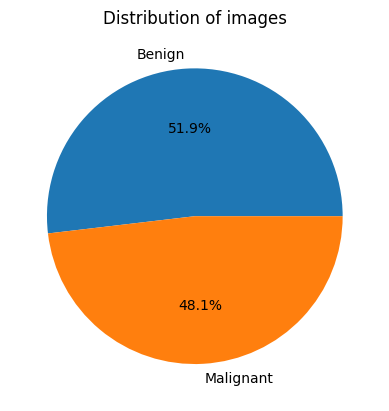

In [4]:
train_path = '/home/wellington/miniforge3/envs/tf_gpu/DATA/melanoma_cancer_dataset/train'
test_path  = '/home/wellington/miniforge3/envs/tf_gpu/DATA/melanoma_cancer_dataset/test'

# Count images and plot distribution
ben = len(os.listdir(os.path.join(train_path, 'benign'))) + \
      len(os.listdir(os.path.join(test_path,  'benign')))
mal = len(os.listdir(os.path.join(train_path, 'malignant'))) + \
      len(os.listdir(os.path.join(test_path,  'malignant')))
print(f"number of images benign: {ben}")
print(f"number of images malignant: {mal}")
plt.pie([ben, mal], labels=['Benign', 'Malignant'], autopct='%1.1f%%')
plt.title("Distribution of images")
plt.show()

In [5]:
# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

generator_args = dict(target_size=(224, 224), color_mode='rgb', batch_size=32, seed=42, class_mode='categorical')
train_generator = train_datagen.flow_from_directory(train_path, subset='training', shuffle=True, **generator_args)
valid_generator = valid_datagen.flow_from_directory(train_path, subset='validation', shuffle=False, **generator_args)
test_generator  = test_datagen.flow_from_directory(test_path, shuffle=False, **generator_args)

# Compute class weights
y = np.array(train_generator.classes)
classes = np.unique(y)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = {int(c): w for c, w in zip(classes, weights)}
print('Class weights:', class_weight_dict)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}


In [ ]:
# 3. Compute class weights
y = train_gen.classes
classes = np.unique(y)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y)
class_weight_dict = {i: w for i, w in enumerate(weights)}
print("Class weights:", class_weight_dict)

In [ ]:
import cv2

plt.figure(figsize=(12, 6))  
for i,img in enumerate (os.listdir(train_path+'/'+'benign')[:8]):
    # get paths for images
    img_path= os.path.join(train_path+'/'+'benign',img)
    # convert to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # show img
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title("Benign")
    plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
for i,img in enumerate (os.listdir(train_path+'/'+'malignant')[:8]):
    # get paths for images
    img_path=os.path.join(train_path+'/'+'malignant',img)
    img=cv2.imread(img_path)
    # convert to RGB  
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # show imgs
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title("Malignant")
    plt.axis("off")

plt.show()

In [ ]:
# Build model
def build_model(learning_rate=1e-3, trainable_resnet=False):
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
    resnet.trainable = trainable_resnet
    model = tf.keras.Sequential([
        resnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.01))
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc', curve='PR'),
            tf.keras.metrics.Precision(name='precision', class_id=1),
            tf.keras.metrics.Recall(name='recall', class_id=1)
        ]
    )
    return model

model = build_model(learning_rate=1e-3, trainable_resnet=False)
model.summary()

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_recall', mode='max', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_recall', mode='max', factor=0.5, patience=3, min_lr=1e-7)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_recall', mode='max', save_best_only=True)

In [ ]:
# Stage 1: Train with frozen ResNet
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

In [ ]:
# Stage 2: Fine-tune top ResNet blocks
model = build_model(learning_rate=1e-5, trainable_resnet=True)
# Freeze first 50 layers
for layer in model.layers[0].layers[:50]: layer.trainable = False

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, checkpoint]
)

# Save the fine-tuned model
model.save('melanoma_classifier_finetuned.h5')

In [ ]:
# Stage 3: Deeper fine-tuning
loaded = tf.keras.models.load_model('best_model.h5', compile=True)
# Unfreeze more layers
for layer in loaded.layers[0].layers[:100]: layer.trainable = False

loaded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc', curve='PR'),
            tf.keras.metrics.Precision(name='precision', class_id=1),
            tf.keras.metrics.Recall(name='recall', class_id=1)]
)

In [ ]:
history_deeper = loaded.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_recall', mode='max', factor=0.5, patience=2, min_lr=1e-8),
        ModelCheckpoint('best_model_deeper.h5', monitor='val_recall', mode='max', save_best_only=True)
    ]
)


In [ ]:

# Final evaluation
results = loaded.evaluate(test_generator)
print('Test results after deeper fine-tuning:', results)

In [ ]:
# plot curves

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']  


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title("Loss Curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# plot curves

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

acc = history_finetune.history['accuracy']  
val_acc = history_finetune.history['val_accuracy']  


plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title("Loss Curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

2025-07-16 17:13:47.595359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: malignant
Confidence: 97.33%


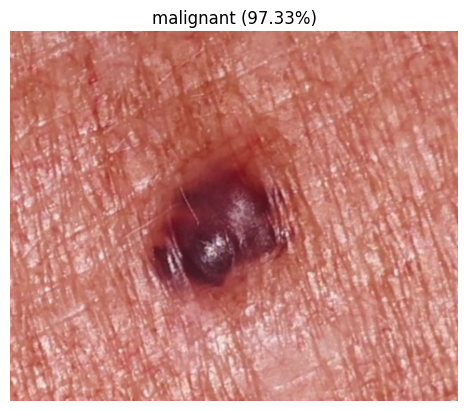

In [18]:
model = tf.keras.models.load_model('melanoma_classifier_finetuned.h5')
import cv2
def predict_image(img_path, model, index_to_label):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_preprocessed = preprocess_input(img_resized)
    img_input = np.expand_dims(img_preprocessed, axis=0)

    pred = model.predict(img_input)[0]
    class_index = np.argmax(pred)
    confidence = pred[class_index]
    class_label = index_to_label[class_index]

    print(f"Predicted Class: {class_label}")
    print(f"Confidence: {confidence * 100:.2f}%")

    plt.imshow(img_rgb)
    plt.title(f"{class_label} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()


img_path = '/home/wellington/miniforge3/envs/tf_gpu/DATA/Mar_mole.jpg'
predict_image(img_path, model, {v: k for k, v in test_generator.class_indices.items()})


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
preds = loaded.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
for file in ['best_model.h5', 'melanoma_classifier_finetuned.h5', 'best_model_deeper.h5']:
    model = tf.keras.models.load_model(file)
    print(f"Evaluating {file}")
    result = model.evaluate(test_generator)
    print(result)